# Lab Session 6: Recurrent Neural Networks

In this lab we build RNNs from scratch to understand their mechanics before using PyTorch's optimised implementations. We'll train a character-level language model on H.G. Wells' "The Time Machine".

**Reference:** [D2L Chapter 9-10](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

## Learning Objectives
1. **Implement the RNN recurrence** from first principles
2. **Understand hidden states** and how they carry information across time steps
3. **Build a character-level language model** that predicts the next character
4. **Compare architectures:** vanilla RNN → LSTM → GRU

## Prerequisites
- Backpropagation and gradient descent
- PyTorch basics (`nn.Module`, tensors, autograd)
- Familiarity with classification problems

In [ ]:
# Standard library
import math
import os
import re
import time

# PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

## Part 1: Implementing a Vanilla RNN from Scratch

### The Key Idea
RNNs maintain a **hidden state** $H_t$ that serves as "memory" - it accumulates information from all previous inputs in the sequence. At each time step, the hidden state is updated based on:
1. The current input $X_t$
2. The previous hidden state $H_{t-1}$

### The RNN Recurrence Equation

$$H_t = \phi(X_t W_x + H_{t-1} W_h + b)$$

Where:
- $X_t \in \mathbb{R}^{d}$ is the input at time $t$
- $H_t \in \mathbb{R}^{h}$ is the hidden state
- $W_x \in \mathbb{R}^{d \times h}$ projects input to hidden dimension
- $W_h \in \mathbb{R}^{h \times h}$ transforms previous hidden state
- $\phi$ is typically $\tanh$ (squashes to $[-1, 1]$)

### Backpropagation Through Time (BPTT)

To understand why vanilla RNNs struggle with long sequences, consider how gradients flow backwards:

$$\frac{\partial H_T}{\partial H_k} = \prod_{t=k+1}^{T} \frac{\partial H_t}{\partial H_{t-1}} = \prod_{t=k+1}^{T} W_h^\top \cdot \text{diag}(\phi'(z_t))$$

Since $|\phi'(z)| \leq 1$ for $\tanh$:
- If $\|W_h\| < 1$: gradients **vanish** exponentially as $T - k$ grows
- If $\|W_h\| > 1$: gradients **explode** exponentially

**Question:** What happens when we try to learn dependencies spanning 100+ time steps?

In [ ]:
class RNN(nn.Module):
    """Vanilla RNN implemented from scratch.
    
    Implements the recurrence: H_t = tanh(X_t @ W_x + H_{t-1} @ W_h + b)
    
    Args:
        num_inputs: Dimension of input vectors
        num_hiddens: Dimension of hidden state
        sigma: Standard deviation for weight initialisation (small to avoid saturation)
    """
    
    def __init__(self, num_inputs: int, num_hiddens: int, sigma: float = 0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        # --- Learnable Parameters ---
        # Input-to-hidden: projects d-dimensional input to h-dimensional hidden space
        self.W_x = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        
        # Hidden-to-hidden: enables information flow across time steps
        self.W_h = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        
        # Bias term
        self.b = nn.Parameter(torch.zeros(num_hiddens))

        # tanh squashes to [-1, 1], helping prevent unbounded growth
        self.activation_func = torch.tanh

    def forward(self, X, state=None):
        """Process a sequence through the RNN.
        
        Args:
            X: Input tensor of shape (num_steps, batch_size, num_inputs)
            state: Optional initial hidden state
            
        Returns:
            outputs: List of hidden states [H_1, H_2, ..., H_T]
            state: Final hidden state H_T
        """
        outputs = []
        
        # Initialise hidden state to zeros if not provided
        if state is None:
            state = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            state, _ = state
        
        # Process each time step sequentially
        for x_t in X:
            # Core RNN computation: H_t = tanh(X_t @ W_x + H_{t-1} @ W_h + b)
            state = self.activation_func(
                torch.matmul(x_t, self.W_x) +      # Input contribution
                torch.matmul(state, self.W_h) +    # Previous state contribution  
                self.b                              # Bias
            )
            outputs.append(state)
        
        return outputs, state

    def display_forward(self, X, state=None):
        """Forward pass with visualisation - useful for understanding dynamics.
        
        Same as forward() but displays input and hidden state at each step.
        Pauses 3 seconds between steps for observation.
        """
        outputs = []
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

        if state is None:
            state = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            state, _ = state
            
        for t, x_t in enumerate(X):
            clear_output(wait=True)
            
            state = self.activation_func(
                torch.matmul(x_t, self.W_x) +
                torch.matmul(state, self.W_h) +
                self.b
            )
            outputs.append(state)

            # Visualise current input and hidden state
            ax0.clear()
            sns.heatmap(x_t.detach().numpy(), ax=ax0, annot=True, cbar=False, fmt='.1f')
            ax0.set_title(f'Input $X_{{{t}}}$')
            
            ax1.clear()
            sns.heatmap(state.detach().numpy(), ax=ax1, annot=True, cbar=False, fmt='.2f')
            ax1.set_title(f'Hidden state $H_{{{t}}}$')
            
            plt.tight_layout()
            display(fig)
            time.sleep(3)

        return outputs, state

Text(0.5, 23.52222222222222, 'Num of input')

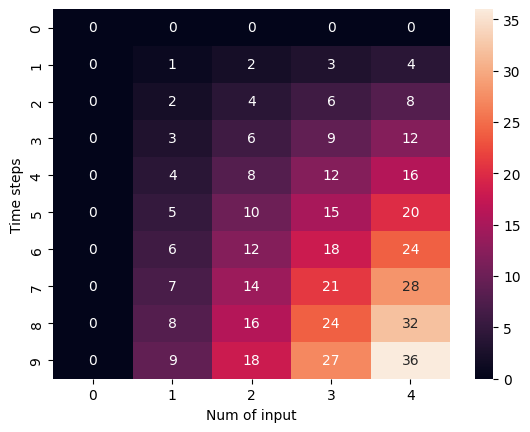

In [ ]:
# Create a simple synthetic input sequence for visualisation
# Each row is a time step, each column is an input feature
batch_size = 1
num_inputs = 5
num_steps = 10
num_hiddens = 5

# Create input where values increase linearly with time
# This makes it easy to see how information accumulates
X = torch.stack([torch.arange(num_inputs) * t for t in range(num_steps)])
X = X.unsqueeze(1)  # Add batch dimension: (num_steps, batch_size, num_inputs)

# Visualise the input sequence
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(X.squeeze().numpy(), ax=ax, annot=True, cbar=True, fmt='.0f')
ax.set_ylabel('Time step $t$')
ax.set_xlabel('Input feature dimension')
ax.set_title('Input sequence $X$')
plt.show()

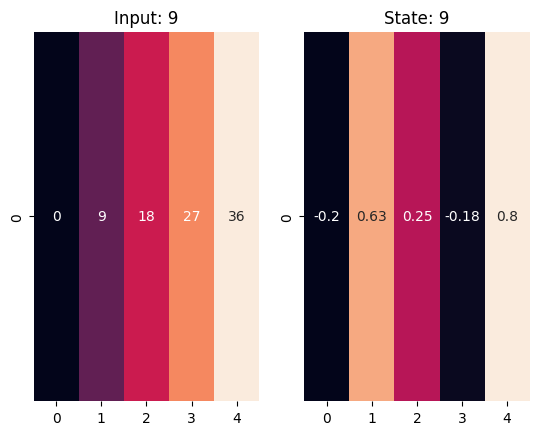

([tensor([[0., 0., 0., 0., 0.]], grad_fn=<TanhBackward0>),
  tensor([[-0.0247,  0.0826,  0.0299, -0.0203,  0.1239]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.0469,  0.1636,  0.0578, -0.0401,  0.2410]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.0692,  0.2426,  0.0857, -0.0600,  0.3516]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.0915,  0.3185,  0.1136, -0.0799,  0.4533]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.1138,  0.3906,  0.1413, -0.0997,  0.5445]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.1361,  0.4582,  0.1690, -0.1195,  0.6246]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.1584,  0.5209,  0.1965, -0.1394,  0.6935]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.1806,  0.5785,  0.2239, -0.1591,  0.7518]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.2029,  0.6309,  0.2510, -0.1788,  0.8004]],
         grad_fn=<TanhBackward0>)],
 tensor([[-0.2029,  0.6309,  0.2510, -0.1788,  0.8004]],
        grad_fn=<TanhBackward0>))

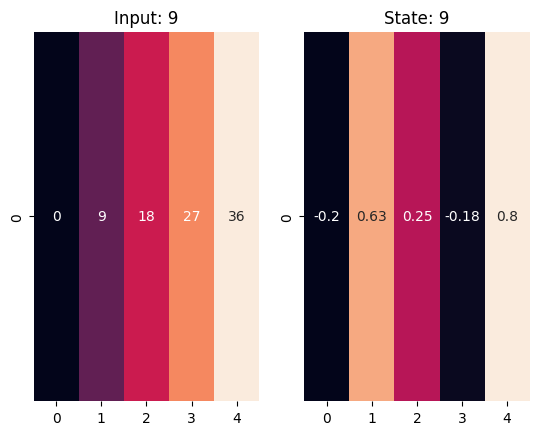

In [ ]:
# Instantiate RNN and run the visualisation
rnn = RNN(num_inputs=num_inputs, num_hiddens=num_hiddens)

# Uncomment to see effect of setting weights to ones (causes rapid saturation)
# rnn.W_x = nn.Parameter(torch.ones_like(rnn.W_x))
# rnn.W_h = nn.Parameter(torch.ones_like(rnn.W_h))

# Watch how hidden state evolves as we process each input
outputs, final_state = rnn.display_forward(X.to(torch.float))

### Observations from the Visualisation

Notice how the hidden state evolves:
- Early time steps: Hidden values are small (weights initialised near zero)
- Later time steps: Values accumulate but stay bounded by $\tanh \in [-1, 1]$

**Try this:** Uncomment the lines that set weights to ones and re-run. You'll see:
- Hidden state values quickly saturate to $\pm 1$
- This is why careful initialisation matters - saturated tanh has near-zero gradient!

**Question:** What would happen if we used ReLU instead of tanh? (Hint: consider unbounded growth)

## Part 2: Loading and Preprocessing Text Data

We'll work with H.G. Wells' "The Time Machine" - a classic text that's:
- **Public domain** (freely available)
- **Clean prose** without special formatting
- **Long enough** for meaningful training (~30k characters)

We'll use **character-level** tokenisation where each character is a token. This is simpler than word-level but produces longer sequences. Modern language models (GPT, etc.) use subword tokenisation as a middle ground.

In [ ]:
# Download the text file (curl works on macOS, wget on Linux)
import os
import urllib.request

file_name = 'timemachine.txt'
url = 'http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'

if not os.path.exists(file_name):
    print(f'Downloading {file_name}...')
    urllib.request.urlretrieve(url, file_name)
    print('Done!')
else:
    print(f'{file_name} already exists')

--2025-10-12 19:03:41--  http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 65.8.246.108
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|65.8.246.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178979 (175K) [text/plain]
Saving to: ‘timemachine.txt’

timemachine.txt     100%[===================>] 174.78K  --.-KB/s    in 0.1s    

2025-10-12 19:03:41 (1.48 MB/s) - ‘timemachine.txt’ saved [178979/178979]



## Sequential Data and the Sliding Window Approach

Natural language is inherently sequential - the meaning of a word depends on context. Sequential data has two key properties:

1. **Order matters:** "the cat sat on the mat" ≠ "mat the on sat cat the"
2. **Variable length:** Sentences can be any length

### Training with Sliding Windows

We create training examples using a **sliding window** of fixed length (`num_steps`):

```
Text:    "the time machine"
Window:  [t,h,e, ,t] → predict [h,e, ,t,i]  (next chars)
         [h,e, ,t,i] → predict [e, ,t,i,m]
         [e, ,t,i,m] → predict [ ,t,i,m,e]
         ...
```

Each input sequence predicts the **next character at each position**. This is exactly how GPT-style models work, but at a much larger scale with subword tokens.

## Example

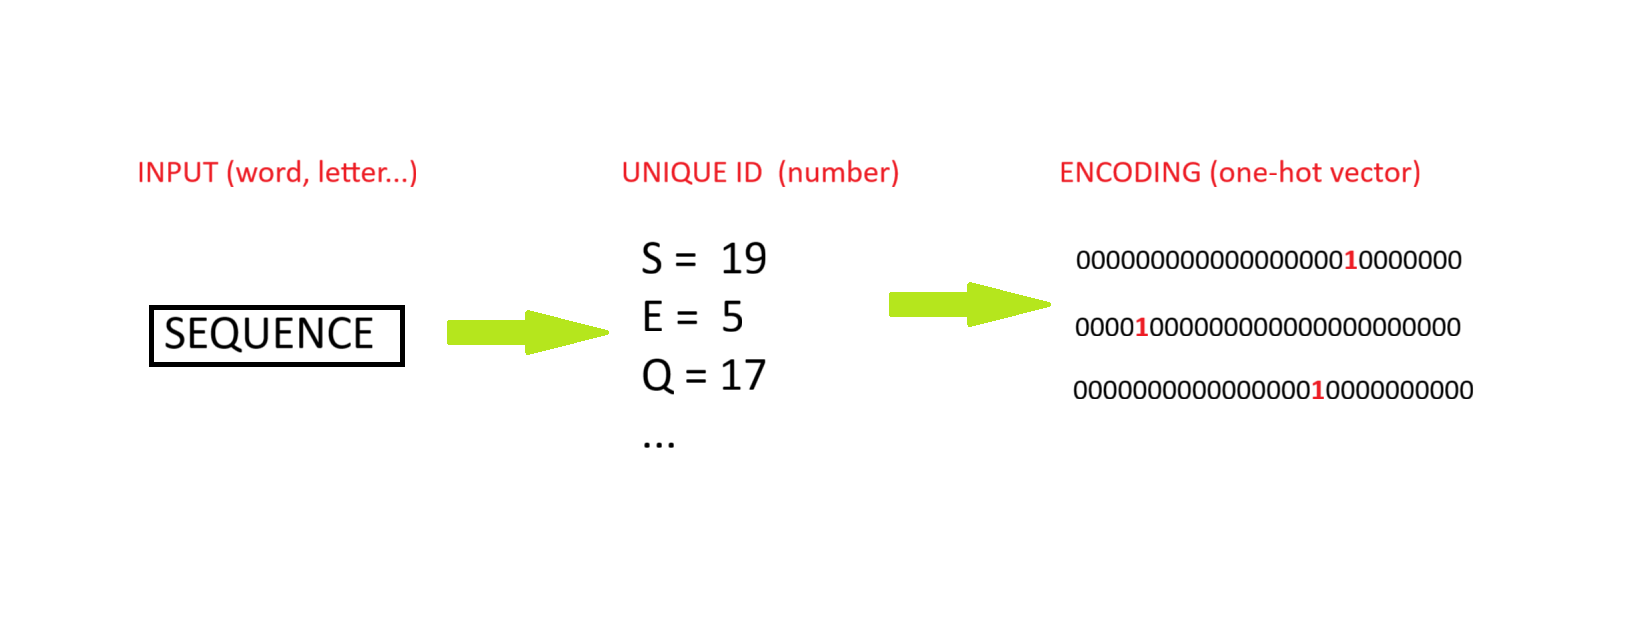

In [ ]:
from torch.utils.data import Dataset, DataLoader
from collections import Counter


class Vocab:
    """Vocabulary mapping between tokens and integer indices.
    
    Handles the conversion between raw tokens (characters) and their integer
    representations needed for neural network processing.
    
    Attributes:
        idx_to_token: List mapping index → token (e.g., idx_to_token[0] = 'a')
        token_to_idx: Dict mapping token → index (e.g., token_to_idx['a'] = 0)
    """
    
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        # Build vocabulary: reserved tokens + frequent tokens
        # Index 0 is reserved for <unk> (unknown tokens)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        # Add tokens that appear at least min_freq times
        for token, freq in self.token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """Convert token(s) to index(es)."""
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """Convert index(es) back to token(s)."""
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[idx] for idx in indices]

    @property
    def unk(self):
        return 0  # Index of <unk> token


class TimeMachine(Dataset):
    """Dataset for character-level language modelling on The Time Machine.
    
    Creates sliding window examples where:
    - Input X: sequence of `num_steps` characters
    - Target Y: the next character after each position in X
    
    Args:
        file_name: Path to text file
        batch_size: Number of sequences per batch
        num_steps: Length of each sequence (context window size)
    """
    
    def __init__(self, file_name, batch_size, num_steps):
        self.batch_size = batch_size
        self.num_steps = num_steps  # Context window length
        
        # Load and preprocess text
        with open(file_name, 'r') as f:
            raw_text = f.read()
        
        # Normalise: lowercase, keep only letters and spaces
        lines = raw_text.lower().split('\n')
        lines = [re.sub('[^a-z ]+', ' ', line) for line in lines if line.strip()]
        self.text = list(' '.join(lines))  # Character list
        
        # Build vocabulary from characters
        self.vocab = Vocab(self.text)
        
        # Convert text to indices
        self.corpus = [self.vocab[char] for char in self.text]
        
        # Create (input, target) pairs using sliding windows
        self._build_sequences()

    def _build_sequences(self):
        """Create input-target pairs from the corpus."""
        # Each sequence of length num_steps has targets shifted by 1
        num_sequences = (len(self.corpus) - 1) // self.num_steps
        
        self.X = []  # Inputs
        self.Y = []  # Targets (next char predictions)
        
        for i in range(num_sequences):
            start = i * self.num_steps
            # Input: characters [start : start + num_steps]
            # Target: characters [start + 1 : start + num_steps + 1]
            self.X.append(self.corpus[start : start + self.num_steps])
            self.Y.append(self.corpus[start + 1 : start + self.num_steps + 1])
        
        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def get_dataloader(self, train=True):
        """Return DataLoader for training or validation."""
        # Simple split: first 80% for training
        split_idx = int(0.8 * len(self))
        if train:
            indices = range(split_idx)
        else:
            indices = range(split_idx, len(self))
        
        subset = torch.utils.data.Subset(self, indices)
        return DataLoader(subset, batch_size=self.batch_size, shuffle=train)


# Create dataset
data = TimeMachine(file_name, batch_size=32, num_steps=16)
dataloader = data.get_dataloader(train=True)

print(f'Vocabulary size: {len(data.vocab)} characters')
print(f'Corpus length: {len(data.corpus):,} characters')
print(f'Number of sequences: {len(data)}')

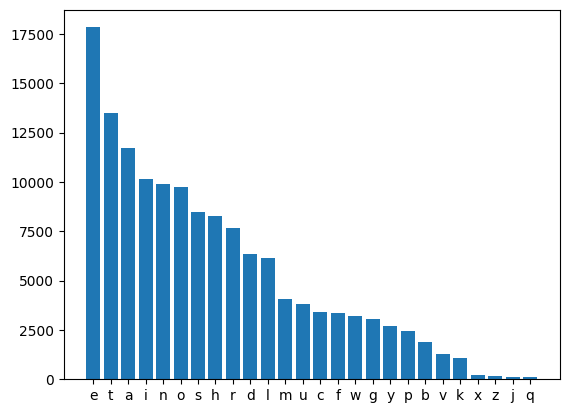

In [ ]:
# Visualise character frequency distribution (Zipf's law)
tokens, freqs = zip(*data.vocab.token_freqs)
tokens, freqs = list(tokens), list(freqs)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(freqs)), freqs, color='steelblue')
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_xlabel('Character')
ax.set_ylabel('Frequency')
ax.set_title('Character frequency distribution (follows Zipf\'s law)')
plt.tight_layout()
plt.show()

# Note: Space is most common, followed by 'e', 't', 'a' - typical for English

In [ ]:
# Inspect a single batch from the dataloader
x, y = next(iter(dataloader))

print(f'Input shape:  {x.shape}  (batch_size, num_steps)')
print(f'Target shape: {y.shape}  (batch_size, num_steps)')
print()

# Show first example: input → target relationship
print('Example (first sequence in batch):')
print(f'  Input:  {"".join(data.vocab.to_tokens(x[0].tolist()))!r}')
print(f'  Target: {"".join(data.vocab.to_tokens(y[0].tolist()))!r}')
print()
print('Notice: target is input shifted by 1 position (predicting next char)')

27

In [ ]:
# Verify shapes match our expectations
print(f'x.shape: {x.shape}  →  (batch_size={x.shape[0]}, num_steps={x.shape[1]})')
print(f'y.shape: {y.shape}  →  same dimensions, shifted by 1')

(torch.Size([16, 32]), torch.Size([16, 32]))

## Part 3: Building a Character-Level Language Model

### The Task
Given a sequence of characters, predict the **next character** at each position.

**Example:** Input "The Time Machi" → Predict "he Time Machin" (shifted by 1)

### Why Classification?
This is a **classification problem** because:
- Input: Sequence of character indices (integers from finite vocabulary)
- Output: Probability distribution over vocabulary at each time step
- Loss: Cross-entropy between predicted distribution and actual next character

### Architecture Overview
1. **One-hot encode** input characters → shape: `(num_steps, batch_size, vocab_size)`
2. **RNN** processes sequence → outputs hidden states at each step
3. **Linear layer** projects hidden state to vocabulary size → logits for each character

rnn-train.svg

The goal is to predict the next token based on the current and past tokens by shifting the original sequence by one token for the target labels. For example, for the word "machine," the input is “machin” and the target is “achine.” During training, a softmax operation is applied at each time step on the output layer, and cross-entropy loss is calculated between the model output and target. The output at time step 3, for instance, is determined by the input sequence “m”, “a”, and “c”, and the loss depends on the probability of predicting the next character “h”. Each token is represented by a vector of vocab size, and the input at each time step is a matrix, adjusted for batch size.

In [ ]:
class RNNLMScratch(nn.Module):
    """RNN-based Language Model using our scratch implementation.
    
    Architecture:
        1. One-hot encoding of input characters
        2. RNN processes sequence, producing hidden states
        3. Linear layer projects hidden states to vocabulary logits
    
    Args:
        rnn: Our custom RNN module
        vocab_size: Number of unique tokens (characters)
    """
    
    def __init__(self, rnn, vocab_size):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        
        # Output projection: hidden_dim → vocab_size
        self.output_layer = nn.Linear(rnn.num_hiddens, vocab_size)

    def one_hot(self, X):
        """Convert integer indices to one-hot vectors.
        
        Input shape:  (batch_size, num_steps) - integer indices
        Output shape: (num_steps, batch_size, vocab_size) - one-hot vectors
        
        Note: We transpose to (num_steps, batch_size, ...) for sequential processing.
        """
        return F.one_hot(X.T, self.vocab_size).float()

    def forward(self, X, state=None):
        """Forward pass through the language model.
        
        Args:
            X: Input indices, shape (batch_size, num_steps)
            state: Optional initial RNN hidden state
            
        Returns:
            Logits for each position, shape (batch_size, num_steps, vocab_size)
        """
        # One-hot encode: (batch, steps) → (steps, batch, vocab)
        embs = self.one_hot(X)
        
        # RNN forward: get hidden states at each step
        rnn_outputs, state = self.rnn(embs, state)
        
        # Stack hidden states and project to vocab
        # rnn_outputs is list of (batch, hidden) → stack to (steps, batch, hidden)
        H = torch.stack(rnn_outputs)
        
        # Project to vocabulary: (steps, batch, hidden) → (steps, batch, vocab)
        logits = self.output_layer(H)
        
        # Transpose back: (steps, batch, vocab) → (batch, steps, vocab)
        return logits.permute(1, 0, 2)

    def predict(self, prefix: str, num_preds: int, vocab):
        """Generate text by sampling from the model.
        
        Args:
            prefix: Starting text to condition on
            num_preds: Number of characters to generate
            vocab: Vocabulary for encoding/decoding
            
        Returns:
            Generated string (prefix + new characters)
        """
        self.eval()  # Set to evaluation mode
        
        # Start with first character of prefix
        outputs = [vocab[prefix[0]]]
        state = None
        
        for i in range(len(prefix) + num_preds - 1):
            # Create input tensor for single character
            X = torch.tensor([[outputs[-1]]])
            embs = self.one_hot(X)
            
            # Get RNN output and update state
            rnn_outputs, state = self.rnn(embs, state)
            
            if i < len(prefix) - 1:
                # Warm-up phase: use actual prefix characters
                outputs.append(vocab[prefix[i + 1]])
            else:
                # Generation phase: sample from model output
                logits = self.output_layer(rnn_outputs[-1])
                next_char = int(torch.argmax(logits, dim=-1).squeeze())
                outputs.append(next_char)
        
        # Convert indices back to characters
        return ' '.join([vocab.idx_to_token[i] for i in outputs])


class TrainClassifier:
    """Simple training loop for the language model."""
    
    def __init__(self, model, train_dataloader, n_epochs=10, lr=0.01):
        self.model = model
        self.train_dataloader = train_dataloader
        self.n_epochs = n_epochs
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_losses = []

    def training_step(self, batch):
        X, Y = batch
        # Forward pass: (batch, steps, vocab)
        logits = self.model(X)
        
        # Reshape for cross-entropy: flatten batch and steps
        # logits: (batch * steps, vocab), Y: (batch * steps,)
        loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), Y.reshape(-1))
        return loss

    def fit(self):
        self.model.train()
        
        for epoch in range(self.n_epochs):
            epoch_loss = 0.0
            pbar = tqdm(self.train_dataloader, desc=f'Epoch {epoch}')
            
            for batch in pbar:
                self.optimizer.zero_grad()
                loss = self.training_step(batch)
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_loss = epoch_loss / len(self.train_dataloader)
            self.train_losses.append(avg_loss)
            print(f'Epoch {epoch}: avg loss = {avg_loss:.4f}, perplexity = {math.exp(avg_loss):.2f}')

In [ ]:
# Create dataset, RNN, and language model
data = TimeMachine(file_name, batch_size=64, num_steps=16)
train_dataloader = data.get_dataloader(train=True)

# Our scratch RNN with input_dim = vocab_size (for one-hot)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)

# Language model wrapping the RNN
model = RNNLMScratch(rnn, len(data.vocab))

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

In [ ]:
# Quick sanity check: RNN should output num_steps hidden states
x, y = next(iter(train_dataloader))
embs = model.one_hot(x)
outputs, state = rnn(embs)
print(f'Number of hidden states: {len(outputs)} (should equal num_steps={data.num_steps})')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 27x32)

In [ ]:
# Verify input/output shapes
print(f'Input shape: {x.shape}  (batch_size, num_steps)')
print(f'One-hot shape: {embs.shape}  (num_steps, batch_size, vocab_size)')

torch.Size([32, 16, 27])

In [ ]:
# Get a fresh batch for training
x, y = next(iter(train_dataloader))

In [ ]:
# Train the language model
trainer = TrainClassifier(model, train_dataloader, n_epochs=10)
trainer.fit()

  0%|          | 0/3130 [00:00<?, ?it/s]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# Generate text from a prompt
# Note: Early in training, outputs will be repetitive or nonsensical
generated = model.predict('there was a time', 10, data.vocab)
print(f'Generated: {generated}')

't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

## Part 4: Using PyTorch's Built-in RNN

Now that we understand the mechanics, let's use `nn.RNN` from PyTorch:
- **Optimised CUDA kernels** for GPU training
- **Handles batching** and sequence packing automatically
- **Easy to swap** for LSTM/GRU (same API)

The key difference: PyTorch handles the recurrence loop internally, so we don't iterate over time steps manually.

In [ ]:
class RNNLMTorch(nn.Module):
    """RNN Language Model using PyTorch's built-in nn.RNN.
    
    Compared to our scratch implementation:
    - nn.RNN handles the recurrence loop internally
    - More efficient, especially on GPU
    - Same API works for LSTM and GRU
    """
    
    def __init__(self, vocab_size: int, num_hiddens: int, sigma: float = 0.01):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        
        # PyTorch's RNN: input_size=vocab_size (one-hot), hidden_size=num_hiddens
        # batch_first=False means input shape is (seq_len, batch, features)
        self.rnn = nn.RNN(vocab_size, num_hiddens)
        
        # Output projection
        self.linear = nn.Linear(num_hiddens, vocab_size)

    def one_hot(self, X):
        """Convert indices to one-hot, transposed for RNN input."""
        return F.one_hot(X.T, self.vocab_size).float()

    def forward(self, X, state=None):
        """Forward pass through language model."""
        embs = self.one_hot(X)  # (seq_len, batch, vocab)
        
        # nn.RNN returns (output, h_n) where:
        # - output: hidden states at all time steps (seq_len, batch, hidden)
        # - h_n: final hidden state (1, batch, hidden)
        rnn_outputs, _ = self.rnn(embs, state)
        
        # Project to vocabulary and transpose
        return self.linear(rnn_outputs).permute(1, 0, 2)

    def predict(self, prefix: str, num_preds: int, vocab):
        """Generate text from a prompt."""
        self.eval()
        state, outputs = None, [vocab[prefix[0]]]
        
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]])
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i + 1]])
            else:
                logits = self.linear(rnn_outputs[-1])
                outputs.append(int(torch.argmax(logits, dim=-1).squeeze()))
        
        return ' '.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
# Train the PyTorch RNN model
model = RNNLMTorch(vocab_size=len(data.vocab), num_hiddens=32)
trainer = TrainClassifier(model, train_dataloader, n_epochs=20)
trainer.fit()

Epoch:19 - Avg loss:2.95308: 100%|██████████| 6260/6260 [00:38<00:00, 160.68it/s]


In [ ]:
# Generate text
generated = model.predict('there was a time', 10, data.vocab)
print(f'Generated: {generated}')

't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

## Part 5: Long Short-Term Memory (LSTM)

### The Vanishing Gradient Problem Revisited

Recall from our BPTT derivation that vanilla RNNs struggle with long sequences:

$$\frac{\partial H_T}{\partial H_k} = \prod_{t=k+1}^{T} W_h^\top \cdot \text{diag}(\phi'(z_t))$$

Since $|\tanh'(z)| \leq 1$, gradients either **vanish** (if $\|W_h\| < 1$) or **explode** (if $\|W_h\| > 1$).

### The LSTM Solution

LSTMs introduce a **cell state** $C_t$ that flows through time with minimal transformation:

$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**Key insight:** When the forget gate $f_t \approx 1$ and input gate $i_t \approx 0$, gradients flow through unchanged:
$$\frac{\partial C_T}{\partial C_k} \approx 1$$

This "gradient highway" allows LSTMs to learn dependencies spanning hundreds of time steps.

### LSTM Gates

Each LSTM cell has three gates controlling information flow:
- **Forget gate** $f_t$: What to discard from cell state
- **Input gate** $i_t$: What new information to store
- **Output gate** $o_t$: What to output from cell state

lstm-0.svg



In [ ]:
class LSTM(nn.Module):
    """LSTM implemented from scratch.
    
    The LSTM addresses vanishing gradients through gating mechanisms that
    control information flow through the cell state.
    
    Gates (all use sigmoid activation → values in [0,1]):
    - Forget gate (f): How much of previous cell state to keep
    - Input gate (i): How much of new candidate to add
    - Output gate (o): How much of cell state to expose as hidden state
    
    Cell state update: C_t = f_t * C_{t-1} + i_t * C̃_t
    Hidden state: H_t = o_t * tanh(C_t)
    """
    
    def __init__(self, num_inputs: int, num_hiddens: int, sigma: float = 0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        # --- Forget gate parameters ---
        # Controls how much of previous cell state to retain
        self.W_xf = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hf = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_f = nn.Parameter(torch.zeros(num_hiddens))

        # --- Input gate parameters ---
        # Controls how much of new candidate to add
        self.W_xi = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hi = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_i = nn.Parameter(torch.zeros(num_hiddens))

        # --- Output gate parameters ---
        # Controls how much of cell state to expose
        self.W_xo = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_ho = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_o = nn.Parameter(torch.zeros(num_hiddens))

        # --- Candidate cell state parameters ---
        # Computes new candidate values to potentially add to cell state
        self.W_xc = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hc = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_c = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, X, state=None):
        """Process sequence through LSTM.
        
        Args:
            X: Input tensor (num_steps, batch_size, num_inputs)
            state: Optional tuple (H_{t-1}, C_{t-1})
            
        Returns:
            outputs: List of hidden states
            (H_t, C_t): Final hidden and cell states
        """
        outputs = []
        
        # Initialise hidden state H and cell state C
        if state is None:
            H = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
            C = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            H, C = state

        for x_t in X:
            # Forget gate: what to discard from cell state
            f_t = torch.sigmoid(x_t @ self.W_xf + H @ self.W_hf + self.b_f)
            
            # Input gate: what new information to store
            i_t = torch.sigmoid(x_t @ self.W_xi + H @ self.W_hi + self.b_i)
            
            # Output gate: what to output
            o_t = torch.sigmoid(x_t @ self.W_xo + H @ self.W_ho + self.b_o)
            
            # Candidate cell state: new values to potentially add
            C_tilde = torch.tanh(x_t @ self.W_xc + H @ self.W_hc + self.b_c)
            
            # Update cell state: forget old + add new
            C = f_t * C + i_t * C_tilde
            
            # Update hidden state: gated output of cell state
            H = o_t * torch.tanh(C)
            
            outputs.append(H)
        
        return outputs, (H, C)

In [ ]:
# Create LSTM-based language model
data = TimeMachine(file_name, batch_size=32, num_steps=16)
train_dataloader = data.get_dataloader(train=True)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=16)
model = RNNLMScratch(lstm, len(data.vocab))

print(f'LSTM parameters: {sum(p.numel() for p in model.parameters()):,}')
print('(Note: 4x more than vanilla RNN due to 4 sets of gate weights)')

### Thought Experiment

**Question:** What happens if $W_{xc}$, $W_{hc}$ and $b_c$ are all zero matrices?

**Hint:** Look at the candidate cell state equation: $\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c)$

<details>
<summary>Answer</summary>

If these weights are zero, then $\tilde{C}_t = \tanh(0) = 0$ for all time steps.

The cell state update becomes $C_t = f_t \odot C_{t-1} + i_t \odot 0 = f_t \odot C_{t-1}$

This means no new information ever enters the cell state - it can only decay! The LSTM degenerates to a simple leaky integrator.
</details>

In [ ]:
class LSTMTorch(RNNLMTorch):
    """LSTM Language Model using PyTorch's nn.LSTM.
    
    Inherits from RNNLMTorch, just swaps nn.RNN for nn.LSTM.
    """
    
    def __init__(self, vocab_size: int, num_hiddens: int, sigma: float = 0.01):
        # Don't call parent __init__ directly - we want LSTM not RNN
        nn.Module.__init__(self)
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        
        # Replace RNN with LSTM
        self.rnn = nn.LSTM(vocab_size, num_hiddens)
        self.linear = nn.Linear(num_hiddens, vocab_size)

    def one_hot(self, X):
        return F.one_hot(X.T, self.vocab_size).float()

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        # LSTM returns (output, (h_n, c_n))
        rnn_outputs, _ = self.rnn(embs, state)
        return self.linear(rnn_outputs).permute(1, 0, 2)

    def predict(self, prefix: str, num_preds: int, vocab):
        self.eval()
        state, outputs = None, [vocab[prefix[0]]]
        
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]])
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i + 1]])
            else:
                logits = self.linear(rnn_outputs[-1])
                outputs.append(int(torch.argmax(logits, dim=-1).squeeze()))
        
        return ' '.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
# Train LSTM model
model = LSTMTorch(len(data.vocab), num_hiddens=32)
trainer = TrainClassifier(model, train_dataloader, n_epochs=20)
trainer.fit()

  0%|          | 0/6260 [00:00<?, ?it/s]

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
# Generate text with LSTM
generated = model.predict('there was a time', 10, data.vocab)
print(f'Generated: {generated}')

't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

## Part 6: Gated Recurrent Unit (GRU)

### GRU: A Simpler Alternative to LSTM

GRUs (Cho et al., 2014) simplify the LSTM architecture:
- **Combine** forget and input gates into a single **update gate**
- **Merge** cell state and hidden state
- **Fewer parameters** → faster training, similar performance

### GRU Gates

- **Reset gate** $r_t$: Controls how much of previous hidden state to forget when computing candidate
- **Update gate** $z_t$: Controls how much of previous hidden state to keep vs. replace

### GRU Equations

$$r_t = \sigma(X_t W_{xr} + H_{t-1} W_{hr} + b_r)$$
$$z_t = \sigma(X_t W_{xz} + H_{t-1} W_{hz} + b_z)$$
$$\tilde{H}_t = \tanh(X_t W_{xh} + (r_t \odot H_{t-1}) W_{hh} + b_h)$$
$$H_t = z_t \odot H_{t-1} + (1 - z_t) \odot \tilde{H}_t$$

**Key insight:** When $z_t \approx 1$, the hidden state passes through unchanged (like LSTM's cell state highway).

gru-1.svg


### Thought Experiment

**Question:** In the GRU update equation $H_t = z_t \odot H_{t-1} + (1 - z_t) \odot \tilde{H}_t$, what happens when $z_t = 1$?

<details>
<summary>Answer</summary>

When $z_t = 1$:
- The hidden state becomes $H_t = 1 \cdot H_{t-1} + 0 \cdot \tilde{H}_t = H_{t-1}$
- The current input is completely ignored
- Information flows unchanged through time (gradient highway!)

This is how GRUs handle long-range dependencies - by learning to keep the update gate high.
</details>

In [ ]:
class GRUScratch(nn.Module):
    """GRU implemented from scratch.
    
    Simpler than LSTM with only 2 gates:
    - Reset gate (r): How much of previous state to forget when computing candidate
    - Update gate (z): Interpolation between old and new state
    
    Key difference from LSTM: No separate cell state, just hidden state.
    """
    
    def __init__(self, num_inputs: int, num_hiddens: int, sigma: float = 0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        # --- Reset gate parameters ---
        self.W_xr = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hr = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_r = nn.Parameter(torch.zeros(num_hiddens))

        # --- Update gate parameters ---
        self.W_xz = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hz = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_z = nn.Parameter(torch.zeros(num_hiddens))

        # --- Candidate hidden state parameters ---
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, X, state=None):
        """Process sequence through GRU."""
        outputs = []
        
        # Initialise hidden state
        if state is None:
            H = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            H, = state  # GRU only has hidden state (no cell state)

        for x_t in X:
            # Reset gate: controls how much past to forget
            r_t = torch.sigmoid(x_t @ self.W_xr + H @ self.W_hr + self.b_r)
            
            # Update gate: interpolation factor
            z_t = torch.sigmoid(x_t @ self.W_xz + H @ self.W_hz + self.b_z)
            
            # Candidate hidden state (reset gate applied before transformation)
            H_tilde = torch.tanh(x_t @ self.W_xh + (r_t * H) @ self.W_hh + self.b_h)
            
            # Interpolate between old and new
            H = z_t * H + (1 - z_t) * H_tilde
            
            outputs.append(H)
        
        return outputs, (H,)

In [ ]:
# Create GRU-based language model
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=16)
model = RNNLMScratch(gru, len(data.vocab))

print(f'GRU parameters: {sum(p.numel() for p in model.parameters()):,}')
print('(Note: 3x more than vanilla RNN due to 3 sets of gate weights, less than LSTM)')

tensor([[ 4,  9, 20,  ..., 19,  8,  1],
        [ 4, 19, 21,  ..., 14,  9, 14],
        [18,  9, 13,  ...,  1, 18,  5],
        ...,
        [15, 13,  2,  ..., 15, 18, 11],
        [ 1,  8,  5,  ..., 18,  5,  3],
        [18,  5, 23,  ..., 19, 25,  3]])

In [ ]:
# Train GRU model
trainer = TrainClassifier(model, train_dataloader, n_epochs=10)
trainer.fit()

In [ ]:
# Generate text with GRU
generated = model.predict('there was a time', 10, data.vocab)
print(f'Generated: {generated}')

AttributeError: 'GRUScratch' object has no attribute 'num_hiddens'

## Summary: Comparing RNN Architectures

| Architecture | Parameters | Long-Range Dependencies | Training Speed |
|-------------|------------|------------------------|----------------|
| **Vanilla RNN** | Fewest (~$h^2 + dh$) | Poor (vanishing gradients) | Fastest |
| **LSTM** | Most (~$4(h^2 + dh)$) | Good (cell state highway) | Slowest |
| **GRU** | Medium (~$3(h^2 + dh)$) | Good (update gate) | Medium |

### Key Takeaways

1. **RNNs process sequences** by maintaining hidden state that accumulates information over time

2. **Vanishing gradients** limit vanilla RNNs to short-range dependencies:
   - Gradient: $\frac{\partial H_T}{\partial H_k} = \prod W_h^\top \cdot \text{diag}(\phi')$ → vanishes exponentially

3. **Gating mechanisms** (LSTM/GRU) solve this by creating "gradient highways":
   - LSTM: Cell state $C_t$ flows with minimal transformation
   - GRU: Update gate $z_t$ interpolates between old and new state

4. **Practical advice:**
   - Start with LSTM (most robust)
   - Try GRU if training is slow (fewer parameters, often similar performance)
   - Vanilla RNN only for very short sequences

### Looking Ahead

Modern NLP has largely moved beyond RNNs to **Transformers** (BERT, GPT), which:
- Process sequences in parallel (much faster)
- Use attention instead of recurrence
- But understanding RNNs helps understand attention mechanisms!

**Next lab:** We'll explore more advanced NLP tasks and architectures.